## An Agentic RAG System
An agentic RAG system on Computer Science domain knowledge


#### Importing require libraries

In [1]:
import os
from dotenv import load_dotenv
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph, MessagesState
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.tools import tool
from langchain_core.messages import AIMessage, ToolMessage, HumanMessage, SystemMessage, ToolMessage
from typing import Literal
from langchain_community.document_loaders import PyMuPDFLoader
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_chroma import Chroma
from pathlib import Path
MAX_MB=350

c:\Users\OLASQUARE\Desktop\GEN AI Works\Working_with_RAG\rag_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Load api key and intialize llm

In [2]:
persist_dir= "./chroma_db"
load_dotenv()
llm= ChatOpenAI(model='gpt-4o-mini', temperature=0)

### Load PDF with metadata Document

In [3]:
def _load_pdf(file_path:str):
    loader= PyMuPDFLoader(file_path)
    return loader.load()

In [4]:
def load_pdf_with_metadata(file_path:str,document_name:str, institution:str="University of Ibadan"):
    pages= _load_pdf(file_path)
    for page in pages:
        page.metadata.update({
            "document_name": document_name,
            "institution": institution,
            "page_no": (page.metadata.get("page") or 0)+1,
            "source_file": str(file_path),
        })
    return pages

# Now using the function to load the pdf files
documents=[]
skipped=[]
doc_dir= Path(os.getenv("DOCS_DIR"))
pdfs= sorted(doc_dir.glob("*.pdf"))

if not pdfs:
    print ("No pdf file found")

for i, pdf in enumerate(pdfs,1):
    size_mb=pdf.stat().st_size/(1024 * 1024)
    print(f"[{i}/{len(pdfs)}] Loading: {pdf.name} ({size_mb:.1f} MB)...", flush=True)
    if size_mb>MAX_MB:
        skipped.append((pdf.name, f"Too large ({size_mb:.1f} MB)"))
        print(f"   SKIP (too large)", flush=True)
        continue 
    try:
        pages=load_pdf_with_metadata(pdf,pdf.name)
        documents+=pages
        print(f"Loads: {len(pages)} pages", flush=True)
    except Exception as e:
        skipped.append((pdf.name, str(e)))
        print(f"    SKIP: {pdf.name} -> {e}", flush=True)
# Review loaded docs
print(f"✅ Total loaded pages: {len(documents)}")
if skipped:
    print("\nSkipped files:")
    for s in skipped:
        print(" -", s)


[1/5] Loading: FINAL_Student_Hand_Book.pdf (302.5 MB)...
Loads: 216 pages
[2/5] Loading: GENDER_POLICY_DOMMY.pdf (1.0 MB)...
Loads: 23 pages
[3/5] Loading: handbook.pdf (29.1 MB)...
Loads: 84 pages
[4/5] Loading: MANUAL_OF_STYLE.pdf (0.2 MB)...
Loads: 27 pages
[5/5] Loading: SEXUAL_HASSASSMENT_HANDOUT_DOMMY.pdf (0.9 MB)...
Loads: 12 pages
✅ Total loaded pages: 362


### Chunking the documents

In [6]:
## Chunk document
def chunking (documents):
    splitter= RecursiveCharacterTextSplitter(
        chunk_size= 1000,
        chunk_overlap= 100,
        separators=["\n\n","\n",". "," ",""],
    )
    chunks= splitter.split_documents(documents=documents)
    return chunks
chunks= chunking(documents)
print(f"✅ Complete! with total {len(chunks)} chunks")


✅ Complete! with total 459 chunks


In [7]:
# Add IDs to chunks
import hashlib

def add_chunk_id(chunk):
    key = f"{chunk.metadata.get('document_name')}|{chunk.metadata.get('page_no')}|{chunk.page_content}"
    return hashlib.sha1(key.encode('utf-8')).hexdigest()

ids = [add_chunk_id(chunk) for chunk in chunks]
print("✅ IDs added to chunks successfully!")

✅ IDs added to chunks successfully!


### Vector Store

In [8]:
# Tnitialize embeddings and vector store
embed= OpenAIEmbeddings(model="text-embedding-3-small")
vectorstore= Chroma(collection_name="UI_Policies",embedding_function=embed, persist_directory=persist_dir)
vectorstore.add_documents(documents=chunks, ids=ids)

vec_cont= vectorstore._collection.count()
print(f" {len(chunks)} chunks added to Chroma and created {vec_cont} vector store", )

 459 chunks added to Chroma and created 459 vector store


In [9]:
# Testing the retriever
query="What is full meaning of UI"
result= vectorstore.similarity_search(query=query,k=4)
result[0].page_content

"WELCOME TO UI!\nUNIVERSITY MOTTO\nRECTE SAPERE FONS\n(For Knowledge and Sound Judgment)\nVision\nTo be a world-class institution for academic excellence geared towards \nmeeting societal needs\nMission\n \nTo expand the frontiers of knowledge through provision of \nexcellent conditions for learning and research.\n \nTo produce graduates who are worthy in character and sound \n \njudgment.\n \nTo contribute to the transformation of society through  \n \ncreativity and innovation. \n \nTo serve as a dynamic custodian of society's salutary values and \nthus sustain its integrity.\n1"

### Creating the Retriever tool

In [10]:
# Tool definition with citation support
@tool
def doc_retriever(query: str)->str:
    """Search knowledge base for relevant University of Ibadan documents and return top sources with citation tags.
    Use this tool when needed to answer any information about University of Ibadan.
    Do not use the tool for general knowledge questions or normal greetings.

    args:
        query: question to search for
    returns: 
        the fetched documents with source metadata
    """
    
    vectorstore= Chroma(collection_name="UI_Policies",persist_directory=persist_dir, embedding_function=embed)
    retreiver= vectorstore.as_retriever(
        search_type="mmr", 
        search_kwargs = {"k": 3, "fetch_k":20 , "lambda_mult":0.5})
    docs= retreiver.invoke(query)

    if not docs:
        return "NO_SOURCES_FOUND"

    # Format with source information for citations
    formatted = "\n\n---\n\n".join(
        f"[Source {i+1}] Document: {doc.metadata.get('document_name', 'Unknown')} (Page {doc.metadata.get('page_no', '?')})\n\nContent:\n{doc.page_content}"
        for i, doc in enumerate(docs)
    )
    return formatted

### Testing the retriever function

In [11]:
# Get count separately
embedding = OpenAIEmbeddings(model="text-embedding-3-small")
vectorstore = Chroma(collection_name="UI_Policies",persist_directory=persist_dir, embedding_function=embedding)
db_count = vectorstore._collection.count()

# Use the tool
query = "University of ibadan was found when?"
results = doc_retriever.invoke(query)

print("Total count is:", db_count)
print(results)

Total count is: 459
[Source 1] Document: handbook.pdf (Page 21)

Content:
ABOUT THE UNIVERSITY OF IBADAN (UI)
UI Main Gate
Congratulations on your admission to the University of Ibadan, the Great 
UI! Welcome to the paths trodden by several generations of great women and 
men. Here is a brief history of UI which is meant to connect you with our rich 
past, link you with our richer present and prepare you to be part of our 
glorious future.
 
Established in 1948, the University of Ibadan, UI as it is fondly referred 
to, is the first University in Nigeria. Until 1962 when it became a full-fledged 
independent University, it was a College of the University of London in a 
special relationship scheme. Today, the University has a total enrolment of 
over 26,000 students shared among 17 different faculties: Arts, Science, 
Basic Medical Sciences, Clinical Sciences, Agriculture, The Social Sciences, 
Education, Veterinary Medicine, Technology, Pharmacy, Law, Public Health, 
Dentistry, Econom

### Binding the llm with tool


In [12]:
tools=[doc_retriever]
llm_with_tool= llm.bind_tools(tools)

## Design the Graph

In [13]:
# system prompt
sys_prompt = SystemMessage(content="""You are a helpful assistant that provides information about University of Ibadan and its policies.
You have access to a document retrieval tool.

DO NOT retrieve documents for these (answer directly in a warm, friendly way):
- Greetings: "Hello", "Hi", "How are you", etc.
- Questions about your capabilities: "What can you help with?", "What do you do?"
- Simple math or general knowledge: "What is 2+2?"
- Casual conversation: "Thank you", "Goodbye"

DO retrieve documents for:
- Questions asking for specific information about University of Ibadan
- Requests for facts, definitions, or explanations about UI policies
- Any question where citing sources would improve the answer

IMPORTANT - When you use retrieved documents:
1. Cite sources using format: (Source X: Document Name, Page Y)
2. Limit citations to the 1-3 most relevant sources
3. Only cite the sources you actually used in your answer
4. If documents don't contain the answer, say so clearly
5. Do not answer questions outside the scope of University of Ibadan except for casual greetings
""")

# Build the assistance node
def assistant(state:MessagesState):
    """Assistant node: Decide to make a tool call or answer directly"""
    msg= [sys_prompt] + state['messages']
    response= llm_with_tool.invoke(msg)
    return{"messages": [response]}

# Define the router node
def should_countinue(state:MessagesState)-> Literal["tools", "__end__"]:
    """Determine whether to call tool or finish"""
    last_msg= state["messages"][-1]
    if last_msg.tool_calls:
        return "tools"
    return "__end__"

# Building the graph
# intialized graph builder
builder= StateGraph(MessagesState)

# let add our nodes
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# let define edges
builder.add_edge(START, "assistant")
builder.add_conditional_edges("assistant", should_countinue,{"tools":"tools", "__end__":END})
builder.add_edge("tools", "assistant")

# let compile our agent with memory
memory= MemorySaver()
agent= builder.compile(checkpointer= memory)


## Visualize the graph

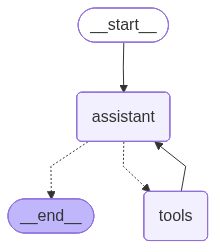

In [14]:
# let see how the graph look like
try:
    display(Image(agent.get_graph().draw_mermaid_png()))
except Exception as e:
    print("Graph flow display failed because:", str(e))

## Testing the Agent

In [15]:
# Helper function to query agent
def query_agent(user_input: str, thread_id: str = "default_session"):
    """Query the agent and determine what decision was made"""
    print(f"\n{'='*70}")
    print(f"👤 User: {user_input}")
    print(f"{'='*70}\n")

    result = agent.invoke(
        {"messages": [HumanMessage(content=user_input)]},
        config={"configurable": {"thread_id": thread_id}}
    )

    # Analyze the message flow to detect tool usage
    used_retriever = False
    final_answer = None

    for i, message in enumerate(result['messages']):
        # Check if this is an AIMessage with tool calls (retriever was invoked)
        if isinstance(message, AIMessage) and message.tool_calls:
            used_retriever = True
        # Get the final response (last AIMessage without tool calls)
        elif isinstance(message, AIMessage) and not message.tool_calls and message.content:
            final_answer = message.content

    # Print final answer
    if final_answer:
        print(f"🤖 Agent: {final_answer}")
    else:
        print(f"⚠️ No response generated!")

    # Summary
    print(f"\n📊 Decision: {'USED RETRIEVER' if used_retriever else 'ANSWERED DIRECTLY'}")
    print(f"{'='*70}\n")


In [16]:
query_agent("Hello! What can you help me with?", "session_1")



👤 User: Hello! What can you help me with?

🤖 Agent: I'm here to provide information about the University of Ibadan, including its policies, programs, and other specific details. If you have any questions about the university, feel free to ask!

📊 Decision: ANSWERED DIRECTLY



In [17]:
query_agent("What are the admission requirements for University of Ibadan?", "session_1")


👤 User: What are the admission requirements for University of Ibadan?

🤖 Agent: The admission requirements for the University of Ibadan (UI) typically include the following criteria for undergraduate programs:

1. **Educational Qualifications**: Candidates must possess a minimum of five O'Level credits in relevant subjects, including English Language and Mathematics, obtained in not more than two sittings.

2. **Unified Tertiary Matriculation Examination (UTME)**: Candidates must sit for the UTME and achieve a score that meets the university's cut-off mark for their chosen course.

3. **Post-UTME Screening**: Candidates who meet the UTME cut-off mark are usually required to participate in the university's Post-UTME screening exercise.

4. **Specific Course Requirements**: Each faculty and program may have additional specific requirements, such as particular subjects that must be passed at O'Level or specific UTME subject combinations.

5. **Age Requirement**: Candidates must be at lea

In [18]:
# Testing 
query_agent("Tell me more about it?", "session_1")


👤 User: Tell me more about it?

🤖 Agent: The admission process for the University of Ibadan (UI) involves several key steps:

1. **Application**: Prospective students must apply through the Joint Admissions and Matriculation Board (JAMB) by registering for the Unified Tertiary Matriculation Examination (UTME). They should select the University of Ibadan as their preferred institution.

2. **O'Level Requirements**: Candidates must have at least five O'Level credits, including English Language and Mathematics, in relevant subjects. These should be obtained in not more than two sittings.

3. **UTME Examination**: Candidates must sit for the UTME and achieve a score that meets or exceeds the university's cut-off mark for their chosen course.

4. **Post-UTME Screening**: After meeting the UTME cut-off, candidates are required to participate in the university's Post-UTME screening exercise, which assesses their readiness for university-level education.

5. **Admission List**: Successful can

In [19]:
query_agent("Give me breif history of UI?", "session_1")



👤 User: Give me breif history of UI?

🤖 Agent: The University of Ibadan (UI) has a rich history that dates back to its establishment in 1948. Here are some key points in its history:

1. **Foundation**: UI was originally founded as a college of the University of London, known as the University College Ibadan. It was established to provide higher education in Nigeria and was part of a special relationship scheme with the University of London.

2. **Independence**: In 1962, UI became a full-fledged independent university, marking a significant milestone in its development. This transition allowed it to establish its own governance and academic programs.

3. **Growth and Development**: Over the years, UI has expanded significantly, now enrolling over 26,000 students across 17 faculties, including Arts, Science, Medicine, Agriculture, and Law, among others.

4. **Pioneering Role**: As the first university in Nigeria, UI has played a crucial role in the development of higher education in t

In [21]:
query_agent("Who is Davido?", "session_1")



👤 User: Who is Davido?

🤖 Agent: I'm here to provide information about the University of Ibadan. If you have any questions related to the university or its policies, feel free to ask!

📊 Decision: USED RETRIEVER

